# Population Inference

This notebook outlines how to derive population redshift distributions from a given collection of redshift PDFs using some of the tools available in `frankenz`.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7001826)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 30})

# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We now want to construct an estimate for the population redshift distribution $P(z|\mathbf{g})$. We can write out the posterior using Bayes Theorem:

$$
P(\rho|\lbrace p_g \rbrace) \propto P(\lbrace p_g \rbrace | \rho) P(\rho) 
$$

where we have suppressed some notation for compactness to write $\rho \equiv P(z|\mathbf{g})$ and $p_g \equiv P(z|g)$. Assuming independence, we can factor the first term to be

$$
P(\lbrace p_g \rbrace | \rho) = \prod_{g} P(p_g|\rho) = \prod_g \int P(z_g|z) P(z|\mathbf{g}) dz
$$

In other words, the posterior probability for the population redshift distribution $P(z|\mathbf{g})$ is based on how much it overlaps the most with each of the individual redshift PDFs $P(z_g | z)$ (with some prior). 

**Note that this result means that the population distribution is _not_ what you get by stacking the individual redshift PDFs**:

$$ P(z|\mathbf{g}) \neq \frac{1}{N_\mathbf{g}}\sum_g P(z_g | z) $$

since there is no guarantee $\frac{1}{N_\mathbf{g}}\sum_g P(z_g | z)$ will maximize the posterior probability.

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

print('Number of observed redshifts:', Nobs)

Number of observed redshifts: 20000


# Redshift Basis

As before, we can make this functional result a bit more concrete by representing our PDFs using some associated discrete **basis** $\lbrace \dots, K(z|z_h), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \int P(z_g | z) K(z | z_h) dz
$$

where the notation $K(z|z_h)$ again is meant to suggest a **kernel density** and differentiate it from $P(z_g|z)$.

## Top-hat Kernels (Histogram)

One common choice of basis is a series of redshift **bins** (i.e. a histogram), which can be modeled using a **top-hat kernel** consisting of a product of **Heavyside functions**

$$
K(z|z_h) = \frac{\mathcal{H}(z - z_h^{-})\mathcal{H}(z_h^{+} - z)}{z_h^{+} - z_h^{-}}
$$

where $z_h^{\pm}$ are the bin edges. In the errorless case where $P(z_g|z) = \delta(z_g - z)$ (where $\delta(\cdot)$ is the Dirac delta function) this just evaluates to $\frac{1}{z_h^{+} - z_h^{-}}$ if $z_g \in \left[z_h^{-}, z_h^{+}\right)$ and $0$ otherwise. In the general case, this just means evaluating the integral above from $z_h^{-}$ to $z_h^{+}$.

Applying Bayes Theorem gives us:

$$ \ln P(\lbrace h_g \rbrace | \boldsymbol{\rho}) = \sum_{g} \ln P(h_g|\boldsymbol{\rho}) = \sum_g \ln\left( \sum_h P(g|h) P(h|\mathbf{g}) \right) $$

where we now used $\boldsymbol{\rho} = \lbrace \dots, P(h|\mathbf{g}), \dots \rbrace$ to indicate a discrete collection of probabilities over $\mathbf{h}$.

In the case where our PDFs are errorless, $P(g|h) = 1$ only in one bin and $0$ in all other bin. This gives 

$$ \ln P(\boldsymbol{\rho}|\lbrace h_g \rbrace) = \sum_h N_h \ln N_h^\prime - N_\mathbf{g} \ln N_{\mathbf{g}} $$
where $P(h|g)=N_h^\prime/N_{\mathbf{g}}$ is the counts/amplitude of the $h$th bin. This is maximized when $N_h^\prime = N_h$, i.e. when the posterior is equal to the number of observed counts in each bin.

This formalism might seem like overkill when the conclusion is that the "right" thing to do for noiseless data is "count up the number of galaxies in each redshift bin and normalize them". While this might seem intuitive, it is important to remember that **this result is special** and *does not* hold in general.

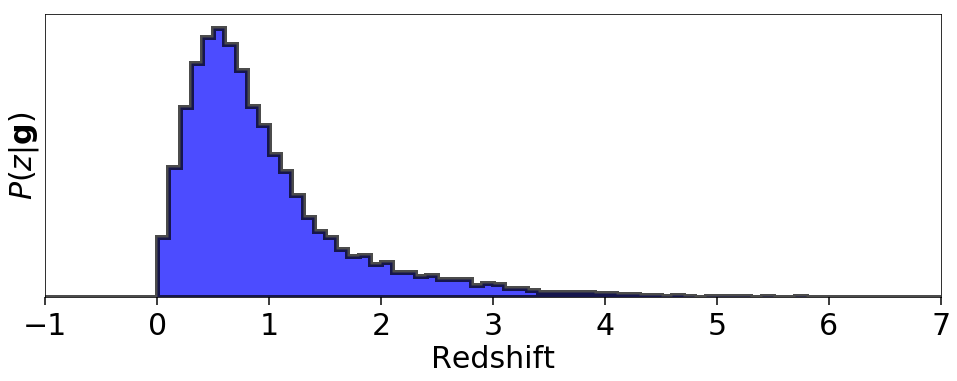

In [4]:
dzbin = 0.1
zbins = np.arange(-1, 7.+1e-5, dzbin)  # redshift bins
zbins_mid = 0.5 * (zbins[1:] + zbins[:-1])  # bin midpoints
Nbins = len(zbins) - 1

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, density=True, edgecolor='black')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.tight_layout()

## Gaussian Kernels (Smooth KDE)

Alternately, we can construct a smooth density estimate by using, e.g., **kernel density estimation** by assigning, e.g., a Gaussian kernel to each point. The estimate for the population redshift distribution is then (by construction)

$$ P(z|\mathbf{g}) = \frac{1}{N_\mathbf{g}} \sum_{g} \mathcal{N}(z|\mu=z_g, \sigma^2=\sigma^2) $$

In other words, we just stack kernels centered around each point. 

We cannot emphasize enough that **this is a heuristic, not the truth**. In general, stacking PDFs/kernels does *not* maximize the posterior probability.

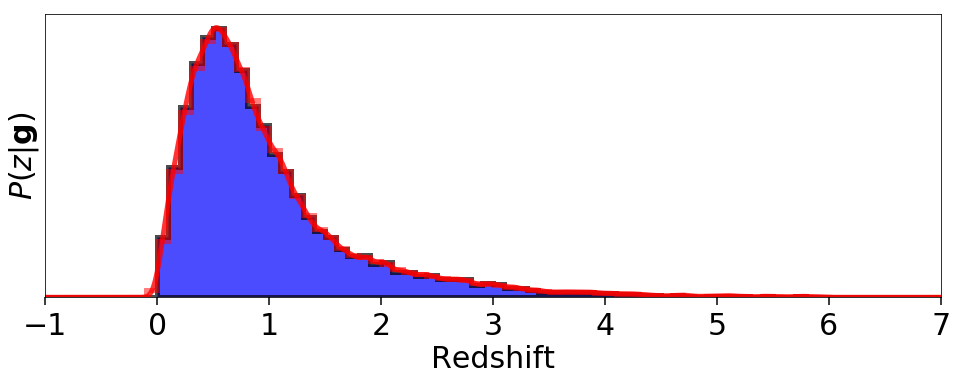

In [5]:
# KDE
dzgrid = 0.01
zgrid = np.arange(-1., 7.+1e-5, dzgrid)
Ngrid, smooth = len(zgrid), 0.05
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * smooth, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, density=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

We can see the disagreement between the two methods by examining the histogrammed version of the KDE $P(z|\mathbf{g})$, which disagrees with the histogram computed directly from the data.

# Noisy Data

Let's say that we're actually dealing with a noisy redshift estimate $\hat{z}_g$. This leaves us with:

$$
P(g|h) = \frac{\int P(\hat{z}_g | z) K(z | z_h) dz}{\sum_{g} \int P(\hat{z}_g | z) K(z | z_h) dz}
$$

Let's assume our errors are Gaussian such that $P(\hat{z}_g|z) = \mathcal{N}(\hat{z}_g|z, \hat{\sigma}_g)$, where we assume the error $\hat{\sigma}_g$ is also estimated but which we will take to be fixed (and correct).

In [6]:
# generate Gaussian PDFs over grid
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

In [7]:
# generate PDFs over bins
zpdf_bins = np.array([frankenz.pdf.gaussian_bin(mu[i], sigma[i], zbins) 
                      for i in range(Nobs)])  # redshift pdfs
zpdf_bins /= zpdf_bins.sum(axis=1)[:,None] * dzbin  # normalizing

To avoid edge effects, for our simulated data we will allow for negative redshifts so that producing a "correct" PDF involves simply shifting the mean of the Gaussian.

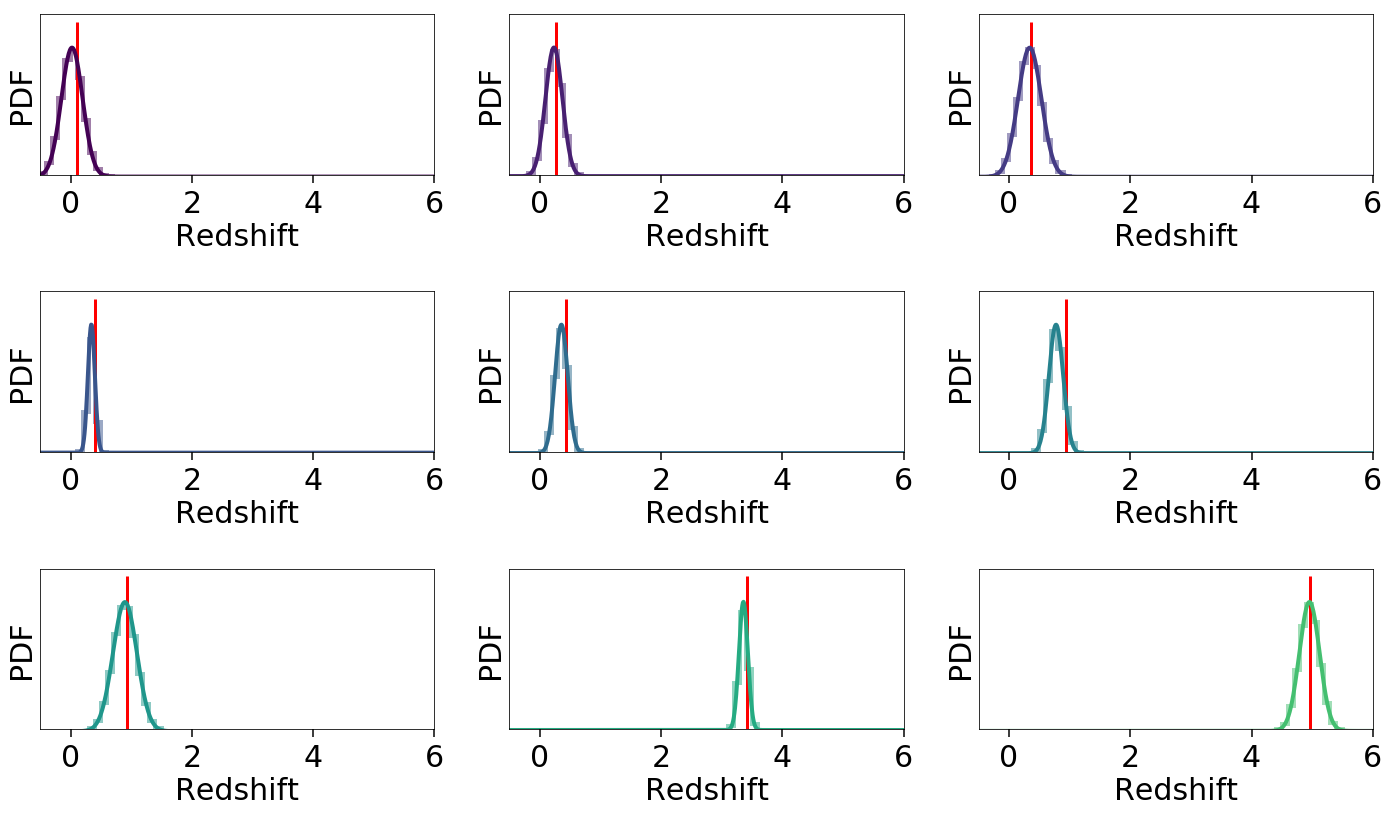

In [8]:
# plot some PDFs
plt.figure(figsize=(20, 12))
Nfigs = (3, 3)
Nplot = np.prod(Nfigs)
colors = plt.get_cmap('viridis')(np.linspace(0., 0.7, Nplot))
idxs = np.random.choice(Nobs, size=Nplot)
idxs = idxs[np.argsort(redshifts[idxs])]
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    plt.plot(zgrid, zpdf[j], color=c, lw=4)
    plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
             color=c, lw=4, alpha=0.5, histtype='step')
    plt.vlines(redshifts[j], 0., max(zpdf[j] * 1.2), color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

We can verify that these are PDFs in a statistical sense by computing the empirical CDF and comparing our results to that expected from a uniform distribution, showcasing that indeed our likelihoods provide proper coverage (as constructed).

K-S Test p-value = 0.412


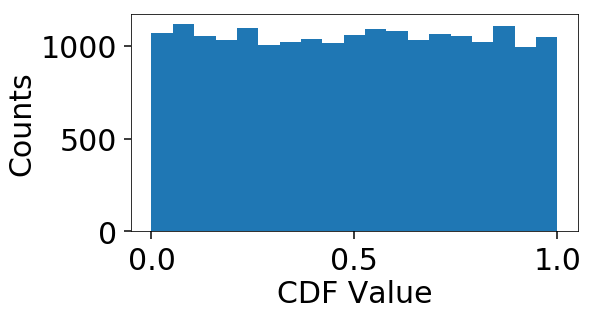

In [9]:
from scipy.stats import norm as normal
from scipy.stats import kstest

# compute CDF draws
cdf_vals = normal.cdf(redshifts, loc=mu, scale=sigma)
plt.figure(figsize=(8, 4))
plt.hist(cdf_vals, bins=np.linspace(0., 1., 20))
plt.xlabel('CDF Value')
plt.ylabel('Counts')

# compute KS test statistic
ks_result = kstest(rvs=cdf_vals, cdf='uniform')
print('K-S Test p-value = {:0.3f}'.format(ks_result[1]))

# Stacking PDFs

Let's now see what happens when we "stack" our PDFs.

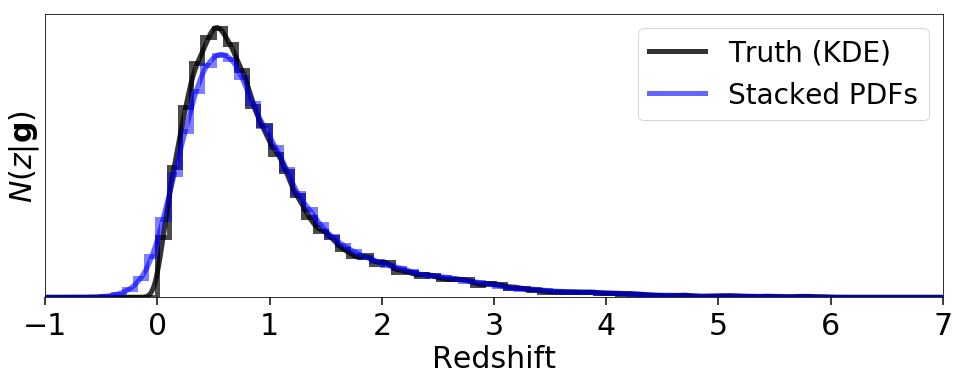

In [10]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='Stacked PDFs')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, density=True)
plt.hist(zbins_mid, bins=zbins, weights=zpdf_bins.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Now that we're using noisy observations (and PDFs) instead of the true (noiseless) observations, we can see stacking the PDFs is *not* a fully accurate reconstruction of the true population redshift number density. This should now intuitively make sense -- the noise broadens the overall distribution, so estimating the population redshift distribution $P(z|\mathbf{g})$ requires **deconvolving** the noisy observations.

## "Quick Fixes"

We've done the wrong thing, but maybe it's not *too* terrible. In particular, maybe we can derive some estimate for the error that encompasses the true distribution, so that if we use our stacked PDFs in some future analysis it won't affect us as much.

One direct way to do this is to try and draw samples from the distribution:

$$ \mathbf{n}_\mathbf{g}^{(1)}, \dots, \mathbf{n}_{\mathbf{g}}^{(k)} \sim P(\mathbf{n}_\mathbf{g}|\mathbf{g}) $$

where $\mathbf{n}_\mathbf{g} = \boldsymbol{\rho} \times N_\mathbf{g}$ is just the normalized effective counts.

In [11]:
# number of samples
Nsamples = 500

### Poisson Approximation

A common approximation is that there are some number of galaxies $N_h$ within the $h$-th redshift bin, and we observe some random realization of this underlying count. The number of objects in each bin (assuming they're independent from each other) then follows a **Poisson distribution** where

$$ n_h \sim \textrm{Pois}(\lambda_h) $$

This treats $n_h(\mathbf{g})$ as a Poisson **random variable** (and $\mathbf{n}_{\mathbf{g}}$ as a Poisson **random vector**) that we want to simuate. The maximum-likelihood solution for our results occurs when $\lambda_h = n_h$.

In [12]:
# draw Poisson samples
pdf1 = zpdf_bins.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

In [13]:
def zplot_bin(samples, label='type', color='blue', downsample=5):
    """Plot our binned draws."""
    [plt.hist(zbins_mid + 1e-5, zbins, 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.05) 
     for i in np.arange(Nsamples)[::downsample]]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zbins, 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([-0.5, 4])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

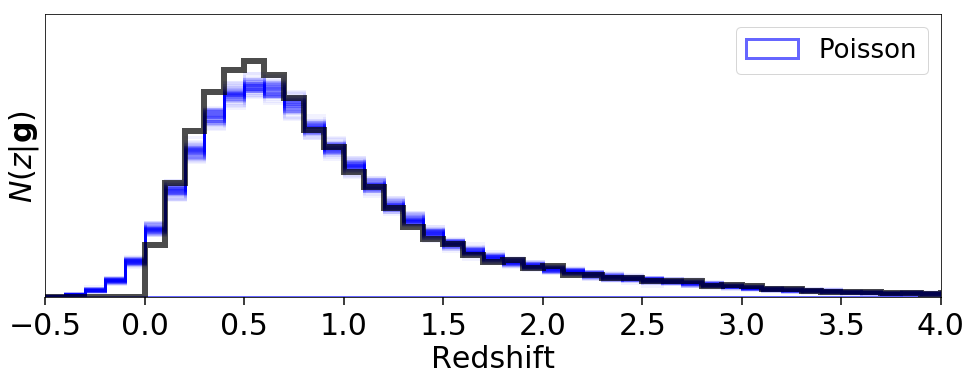

In [14]:
# plotting
plt.figure(figsize=(14, 6))
zplot_bin(pdf1_samples, label='Poisson', color='blue')

The Poisson approximation implies that the number of objects we observe at a given redshift is simply a counting process with mean $\boldsymbol{\mu} = \boldsymbol{\lambda}_{\mathbf{g}} = \mathbf{n}_{\mathbf{g}}$. This isn't quite right, since this assumes the number of objects observed at different $z_h$'s are independent, when we know that there must be *some* covariance due to each object's redshift PDF. More importantly, however, this approximation implies that the total number of objects we observe doesn't remain constant!

Not looking good...

### Multinomial Approximation

One improvement on the Poisson model above is to try and conserve the total number of observed counts $N_\mathbf{g}$. They are then drawn from the **Multinomial distribution**:

$$ \mathbf{n}_{\mathbf{h}}' \sim \textrm{Mult}\left(N_\mathbf{g}, \mathbf{p}_{\mathbf{g}}\right) $$

The maximum-likelihood result is

$$ \mathbf{p}_{\mathbf{g},\textrm{ML}} = \mathbf{n}_\mathbf{g}/N_\mathbf{g} $$

In [15]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

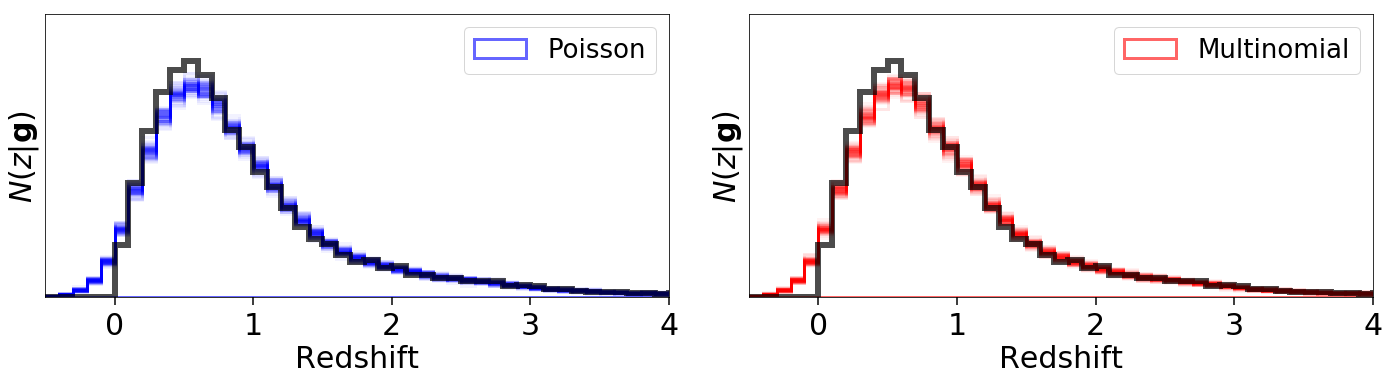

In [16]:
# plotting
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(1, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')

The multinomial approximation implies that the redshift PDF of a random observed galaxy $P(z|g)$ is proportional to the population PDF $P(z|\mathbf{g})$. In other words, a given galaxy is just a random draw from the population. Since the multinomial has the benefit of keeping the overall number of galaxies $N_\mathbf{g}$ constant, it induces *negative* correlations among the individual categories (redshifts). However, this still approximation ignores measurement errors (i.e. individual galaxy PDFs), which can induce additional correlations among redshifts.

Things don't look much better than for the Poisson...

## Individual Redshift Posterior Samples

Any particular galaxy $g$ with PDF $\mathbf{p}_g$ over our redshift bins is actually located at a particular redshift $z_g$, with the corresponding redshift PDF modeling our uncertainty over its true redshift. We can imagine 
simulating the true redshifts $z_g'$ from each PDF $P(z|g)$ over the whole population and then applying the same methods we used when dealing with noiseless observations to get realizations of the $P(z|\mathbf{g})$.

More formally, over our bins the distribution of $z_g$ ($\mathbf{n}_g$) can be modeled as a Categorial (Multinomial) random variable such that

$$
z_g' \sim \textrm{Cat}\left(\mathbf{p}=\mathbf{p}_g\right)
\quad \Leftrightarrow \quad 
\mathbf{n}_g' \sim \textrm{Mult}\left(n=1, \mathbf{p}=\mathbf{p}_g\right)
$$

where $\mathbf{n}_g'$ is $1$ at the bin containing $z_g$ and zero elsewhere.

The redshift number density is then

$$
\mathbf{n}_\mathbf{g}' = \sum_{g} \mathbf{n}_g'
$$

This represents a convolution of a series of Multinomial-distributed random variables with different PDFs. While this doesn't have a simple closed-form solution, it is straightforward to draw samples $\mathbf{n}_{\mathbf{g}}^{(i)}$ from this distribution by drawing redshifts from each galaxy's PDF and then stacking the results. This procedure intuitively seems to make sense: we simulate our uncertainties on $\mathbf{n}_\mathbf{g}$ by simulating our uncertainties on the individual redshifts from $\mathbf{p}_g$.

In [17]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf_bins / zpdf_bins.sum(axis=1)[:, None]
for j in range(Nsamples):
    if j % 50 == 0:
        sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 50 100 150 200 250 300 350 400 450

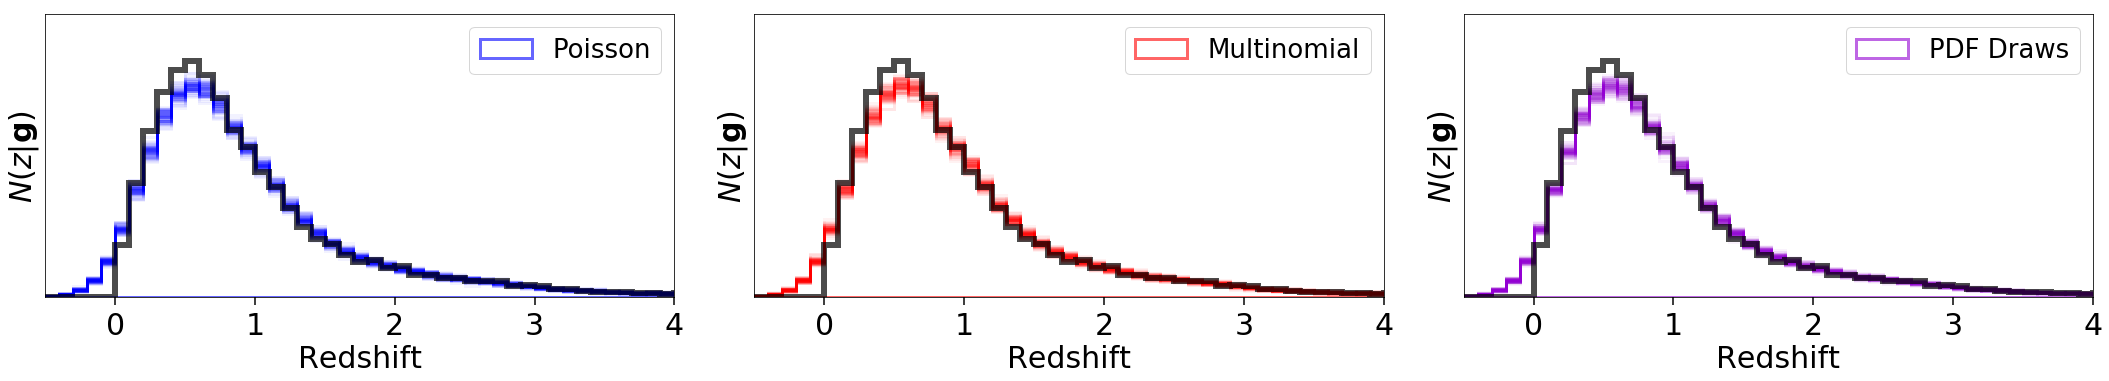

In [18]:
# plotting
plt.figure(figsize=(30, 6))
plt.subplot(1, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(1, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(1, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')

Okay, so that didn't seem to help very much...

# Covariance Structure

In addition to the true distribution, it's also informative to check out the covariances among our $P(z|\mathbf{g})$ draws.

In [19]:
def cov_draws(samples, bin1=(14, 16), bin2=(16, 18), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zbins)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=8, alpha=0.4)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({:6.1f}\leq z < {:6.1f}) \quad [10^3]$'.format(zbins[bin1[0]], 
                                                           zbins[bin1[1]]))
    plt.ylabel(r'$N({:6.1f}\leq z < {:6.1f}) \quad [10^3]$'.format(zbins[bin2[0]], 
                                                           zbins[bin2[1]]))
    plt.legend(fontsize=28, loc=2)
    plt.tight_layout()

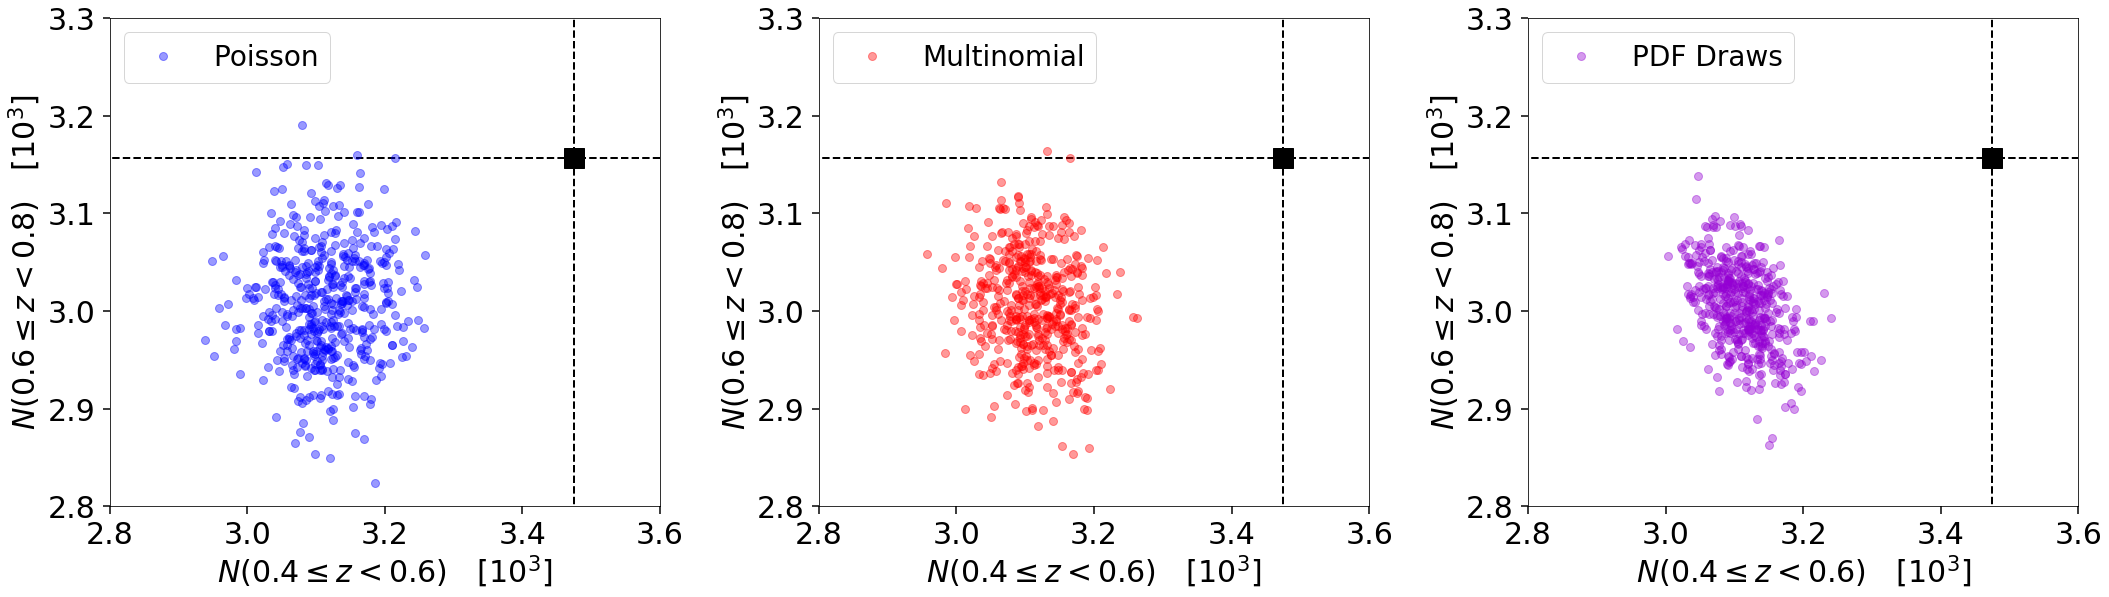

In [20]:
# plotting binned covariance
plt.figure(figsize=(30, 9))
plt.subplot(1, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='blue', label='Poisson')
plt.subplot(1, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='red', label='Multinomial')
plt.subplot(1, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 3.6), ylim=(2.8, 3.3),
          color='darkviolet', label='PDF Draws')

The lack of covariances under the Poisson model makes sense given each bin is treated independently. The slight anti-correlation under the Multinomial model is also what we'd expact given the conservation of total counts (i.e. removing an object from one bins requires putting it in another bin). The PDF draws appear to capture the correct covariance structure overall, but severely underestimate the uncertainties and remains biased.

# Population Modeling

As derived above, the "right" thing to do is to sample from the posterior distribution:

$$
\ln P(\boldsymbol{\rho}|\lbrace \mathbf{p}_g \rbrace) = \ln P(\lbrace \mathbf{p}_g \rbrace | \boldsymbol{\rho}) + \ln P(p_\mathbf{g}) - \ln P(\lbrace \mathbf{p}_g \rbrace) = \sum_g \ln\left( \mathbf{p}_g \cdot \boldsymbol{\rho} \right) + \ln P(\boldsymbol{\rho}) - \ln P(\lbrace \mathbf{p}_g \rbrace)
$$

where $P(\lbrace \mathbf{p}_g \rbrace)$ is a constant that can be ignored and $\cdot$ is the dot product.

## Hyper-Prior

We will take $P(\boldsymbol{\rho})$ to be a **Dirichlet** distribution:

$$ \boldsymbol{\rho} \sim {\rm Dir}\left(\mathbf{m} + \boldsymbol{\alpha}\right) $$

where $\boldsymbol{\alpha} = \mathbf{1}$ are a set of concentration parameters (with 1 being uniform) and $\mathbf{m}$ being a set of counts we've previously observed. We will come back to this particular choice of prior later when we deal with hierarchical models.

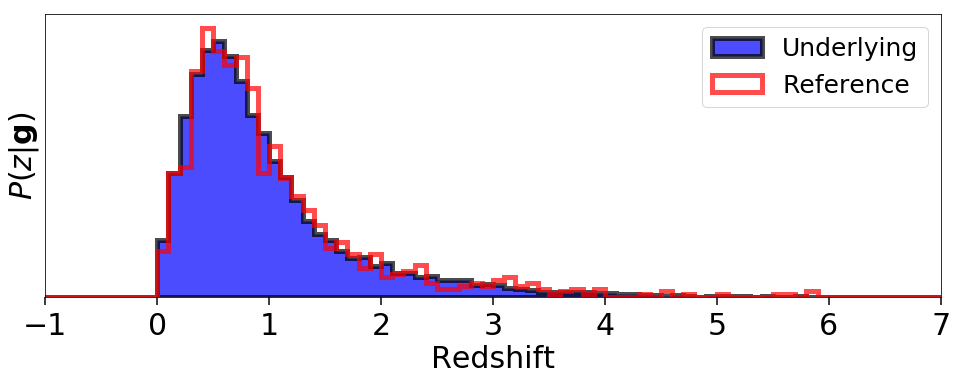

In [21]:
# grab representative set of previous redshifts
Nref = 1000
redshifts_ref = survey.data['redshifts'][-Nref:]

# plotting histogrammed representation
plt.figure(figsize=(14, 6))
plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
         color='blue', alpha=0.7, density=True, edgecolor='black',
         label='Underlying')
plt.hist(redshifts_ref, bins=zbins, histtype='step', lw=5,
         color='red', alpha=0.7, density=True, label='Reference')
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel(r'$P(z|\mathbf{g})$')
plt.legend(fontsize='small')
plt.tight_layout()

In [22]:
alpha = np.ones(Nbins)
counts_ref, _ = np.histogram(redshifts_ref, bins=zbins)

# define our prior
def logprior(x, alpha=None, counts_ref=None):
    
    if alpha is None:
        alpha = np.ones_like(x)
    if counts_ref is None:
        counts_ref = np.zeros_like(x)
    if np.any(x < 0.):
        return -np.inf

    return scipy.stats.dirichlet.logpdf(x, alpha + counts_ref)

## Sampling

We now turn to the challenge of generating samples from our distribution. While there are several ways to theoretically do this, we will focus on **Markov Chain Monte Carlo** methods. Due to the constraint that $\boldsymbol{\rho}$ must sum to 1, we are sampling from this distribution on the $(N_h - 1)$-dimensional **simplex** since the amplitude of the final bin is always determined by the remaining bins. This creates an additional challenge, since changing one bin will always lead to changes in the other bins. 

While we could attempt to sample this distribution directly using **Metropolis-Hastings (MH) updates**, given the number of parameters involved in specifying our population distribution $\boldsymbol{\rho}$ it is likely better to use **Gibbs sampling** to iterate over conditionals. To satisfy the summation constraint, we opt to use an approach where we update bins $(i, j)$ pairwise so that $i^\prime + j^\prime = (i + \Delta i) + (j + \Delta j) = i + j \Rightarrow \Delta j = -\Delta i = z$, where $z$ is now our step-size over the bins. We generate proposals for each random pair of bins using MH proposals where the scale is determined adaptively by estimating the gradient for $\partial/\partial z$ at each iteration to aim for optimal acceptance fractions.

The likelihood and Gibbs sampler are implemented natively is `frankenz`. If we wanted to specify a particular prior, that can also be passed to the sampler as shown below.

In [23]:
from frankenz import samplers

# initialize sampler
sampler = samplers.population_sampler(zpdf_norm)

# run MH-in-Gibbs MCMC
Nburn = 250
sampler.run_mcmc(Nsamples + Nburn, logprior_nz=logprior, prior_args=[alpha, counts_ref])

 Sample 750/750 [lnpost = -64374.276]      

In [24]:
# grab samples
pdf4_samples, pdf4_lnps = sampler.results
pdf4_samples = pdf4_samples[-500:] * Nobs  # truncate and rescale

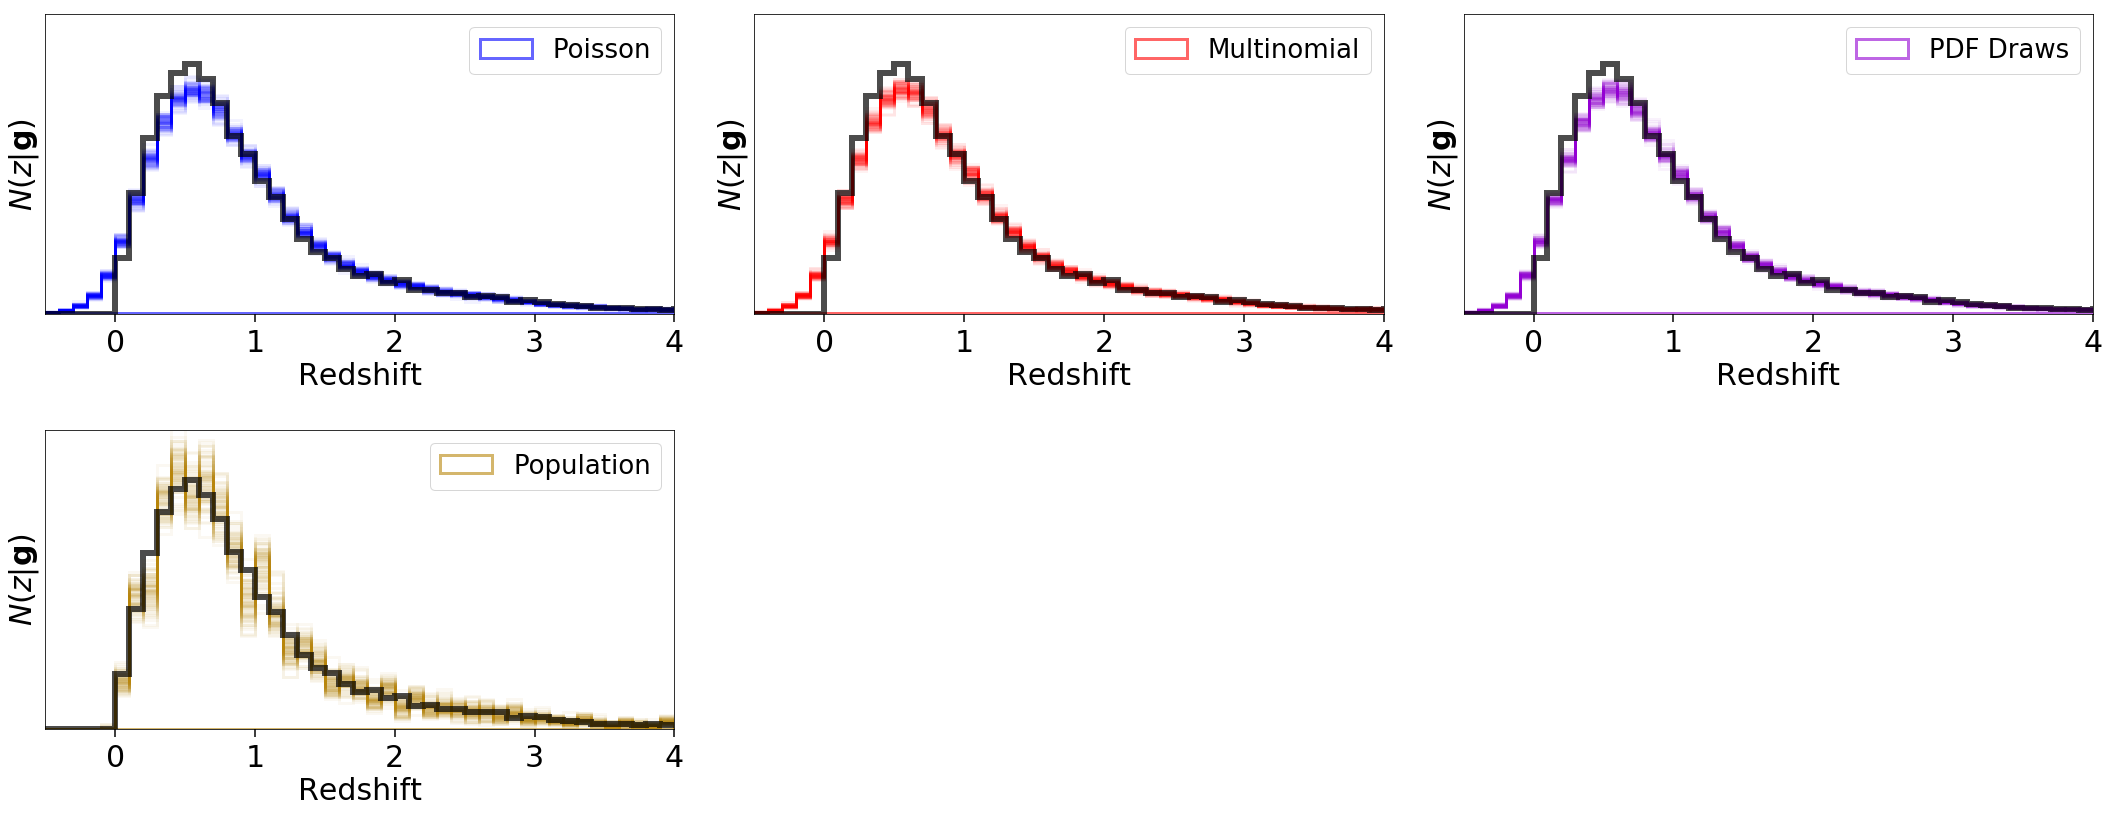

In [25]:
# plotting
plt.figure(figsize=(30, 12))
plt.subplot(2, 3, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 3, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 3, 3)
zplot_bin(pdf3_samples, label='PDF Draws', color='darkviolet')
plt.subplot(2, 3, 4)
zplot_bin(pdf4_samples, label='Population', color='darkgoldenrod')

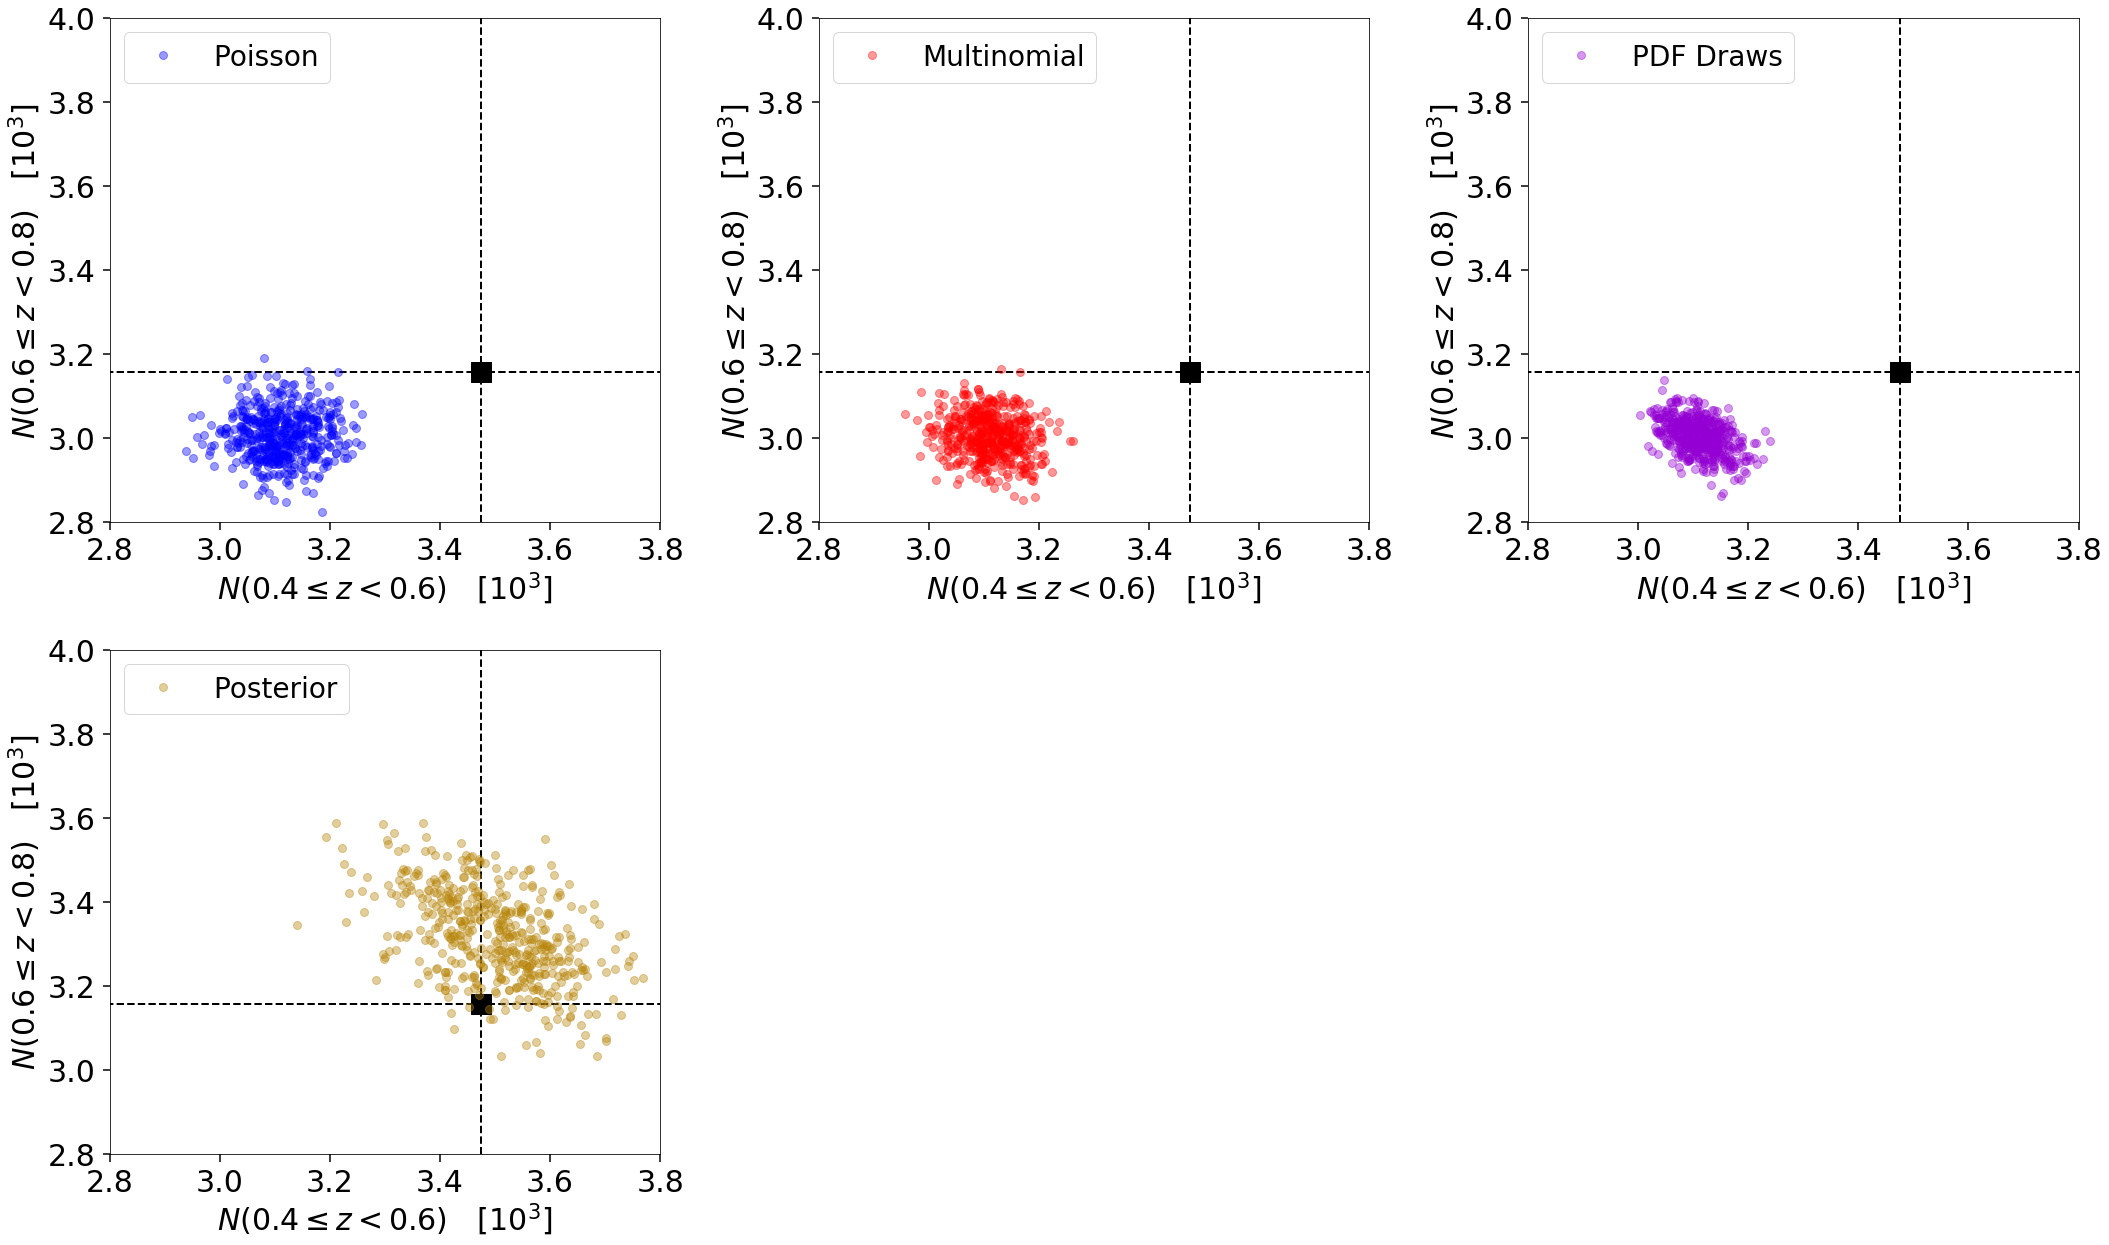

In [27]:
# plotting binned covariance
plt.figure(figsize=(30, 18))
plt.subplot(2, 3, 1)
cov_draws(pdf1_samples,
          xlim=(2.8, 3.8), ylim=(2.8, 4.0),
          color='blue', label='Poisson')
plt.subplot(2, 3, 2)
cov_draws(pdf2_samples,
          xlim=(2.8, 3.8), ylim=(2.8, 4.0),
          color='red', label='Multinomial')
plt.subplot(2, 3, 3)
cov_draws(pdf3_samples,
          xlim=(2.8, 3.8), ylim=(2.8, 4.0),
          color='darkviolet', label='PDF Draws')
plt.subplot(2, 3, 4)
cov_draws(pdf4_samples,
          xlim=(2.8, 3.8), ylim=(2.8, 4.0),
          color='darkgoldenrod', label='Posterior')

As expected, sampling the proper redshift population posterior $P(\boldsymbol{\rho}|\lbrace\mathbf{p}_g\rbrace)$ is able to come somewhat close to reconstructing the underlying redshift distribution. While it retains the same covariance structure as the Monte Carlo PDF draws, the errors are noticeably larger. Our results are still a little off, especially near zero, but that's because we didn't assumed a uniform prior $P(\boldsymbol{\rho})=1$ on $\boldsymbol{\rho}$, which actually is not that great for this particular application. We will deal with this problem next as we turn toward hierarchical modeling.